# A denoising baseline implementation of a residual dense network trained on CIFAR-100 with added Gaussian noise

## Setup

### Imports

In [0]:
!pip install -q --upgrade gsheet-keyring ipython-secrets comet_ml scikit-image imgaug torch torchvision tqdm

In [0]:
from comet_ml import Experiment

import torch
import argparse
from torch import nn
from torch import optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from ipython_secrets import get_secret
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()


from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)


In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 99999;

<IPython.core.display.Javascript object>

### Environment

In [4]:
PROJECT = "fastrino"
DEVICE = "cuda"
DATA_PATH = "./data"
COMET_ML_API_KEY = get_secret("comet-{}".format(PROJECT))

cifar100_train_data = datasets.CIFAR100(
    root=DATA_PATH, train=True, download=True, transform=transforms.ToTensor()
)
cifar100_test_data = datasets.CIFAR100(
    root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor()
)



Files already downloaded and verified
Files already downloaded and verified


### Utilities

In [0]:
class NoisyCIFAR100(Dataset):
    def __init__(self, original_data, noise_mean=0, noise_std=1):
        self.original_data = original_data
        self.noise_mean = noise_mean
        self.noise_std = noise_std

    def __len__(self):
        return len(self.original_data)

    def __getitem__(self, idx):
        image, _ = self.original_data[idx]
        noise = self.noise_mean + self.noise_std * torch.randn_like(
            image
        )
        return image + noise, noise

def load_noisy_data(noise_mean=0, noise_std=1, batch_size=32):
    train_data = NoisyCIFAR100(cifar100_train_data, noise_mean, noise_std)
    test_data = NoisyCIFAR100(cifar100_test_data, noise_mean, noise_std)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def get_arg_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("--num-channels", type=int, default=3)
    parser.add_argument("--num-features", type=int, default=16)
    parser.add_argument("--growth-rate", type=int, default=16)
    parser.add_argument("--num-blocks", type=int, default=3)
    parser.add_argument("--num-layers", type=int, default=5)
    parser.add_argument("--kernel-size", type=int, default=3)
    parser.add_argument("--lr", type=float, default=1e-4)
    parser.add_argument("--batch-size", type=int, default=128)
    parser.add_argument("--noise-mean", type=float, default=0)
    parser.add_argument("--noise-std", type=int, default=0.1)
    parser.add_argument("--num-epochs", type=int, default=5)
    parser.add_argument("--seed", type=int, default=42)

    return parser


def get_criterion():
    return nn.L1Loss()


def get_optimizer(model, lr=0.001):
    return optim.Adam(model.parameters(), lr)


def compute_psnr(prediction, target, max_pixel=255.0):
    return (
        10.0 * ((max_pixel ** 2) / ((prediction - target) ** 2).mean()).log10()
    )


def train(noise_mean=0, noise_std=0.01, device=DEVICE):
    parser = get_arg_parser()
    args = parser.parse_args(args=[])
    args.noise_mean = noise_mean
    args.noise_std = noise_std
    train_loader, test_loader = load_noisy_data(
        args.noise_mean, args.noise_std, args.batch_size
    )
    experiment = Experiment(
        api_key=COMET_ML_API_KEY,
        project_name=PROJECT,
        workspace=PROJECT,
        auto_output_logging=None,
    )
    experiment.log_parameters(vars(args))

    model = ResidualDenseNetwork(
        args.num_channels,
        args.num_features,
        args.growth_rate,
        args.num_blocks,
        args.num_layers,
        args.kernel_size,
    ).to(device)

    criterion = get_criterion()
    optimizer = get_optimizer(model, args.lr)

    for epoch in tqdm(
        range(args.num_epochs), desc="Epoch", unit="epochs"
    ):
        with experiment.train():
            model.train()
            train_psnr = []

            for image, noise in tqdm(
                train_loader, desc="Train images", unit="images"
            ):
                prediction = model(image.to(device))
                loss = criterion(prediction, noise.to(device))

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                current_psnr = compute_psnr(prediction, noise.to(device)).data.item()
                train_psnr.append(current_psnr)
                experiment.log_metric("psnr", current_psnr)
                experiment.log_metric("loss", loss.data.item())
            

            experiment.log_metric("mean_psnr", np.mean(train_psnr))

    with experiment.test():
        model.eval()
        test_losses = []
        test_psnr = []
        for image, noise in test_loader:
            prediction = model(image.to(device))
            test_psnr.append(compute_psnr(prediction, noise.to(device)).data.item())
            test_losses.append(
                criterion(prediction, noise.to(device)).data.item()
            )

        test_psnr = np.mean(train_psnr)
        test_loss = np.mean(test_losses)

        experiment.log_metric("mean_psnr", np.mean(train_psnr))
        experiment.log_metric("mean_loss", np.mean(test_losses))
        
    return test_psnr, test_loss


## Model

In [0]:
# Adapted from the PyTorch implementation of Residual Dense Network 
# for Image Super-Resolution by @yjn870, 
# https://github.com/yjn870/RDN-pytorch

class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=(kernel_size - 1) // 2,
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return torch.cat([x, self.relu(self.conv(x))], 1)


class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super().__init__()
        self.dense_layers = nn.Sequential(
            *[
                DenseLayer(in_channels + growth_rate * layer_idx, growth_rate)
                for layer_idx in range(num_layers)
            ]
        )

        self.local_feature_fusion = nn.Conv2d(
            in_channels + growth_rate * num_layers, growth_rate, kernel_size=1
        )

    def forward(self, x):
        return x + self.local_feature_fusion(self.dense_layers(x))


class ResidualDenseNetwork(nn.Module):
    def __init__(
        self,
        num_channels,
        num_features,
        growth_rate,
        num_blocks,
        num_layers,
        kernel_size=3,
    ):
        super().__init__()
        self.growth_rate = growth_rate
        self.num_features = num_features
        self.num_blocks = num_blocks
        self.num_layers = num_layers

        self.outer_shallow_features = nn.Conv2d(
            num_channels,
            num_features,
            kernel_size=kernel_size,
            padding=(kernel_size - 1) // 2,
        )
        self.inner_shallow_features = nn.Conv2d(
            num_features,
            num_features,
            kernel_size=kernel_size,
            padding=(kernel_size - 1) // 2,
        )

        self.residual_dense_blocks = nn.ModuleList(
            [
                ResidualDenseBlock(
                    self.num_features, self.growth_rate, self.num_layers
                )
            ]
        )
        for _ in range(self.num_blocks - 1):
            self.residual_dense_blocks.append(
                ResidualDenseBlock(
                    self.growth_rate, self.growth_rate, self.num_layers
                )
            )

        self.global_feature_fusion = nn.Sequential(
            nn.Conv2d(
                self.growth_rate * self.num_blocks,
                self.num_features,
                kernel_size=1,
            ),
            nn.Conv2d(
                self.num_features, self.num_features, kernel_size=3, padding=1,
            ),
        )
        self.output = nn.Conv2d(
            self.num_features,
            num_channels,
            kernel_size=kernel_size,
            padding=(kernel_size - 1) // 2,
        )

    def forward(self, x):
        outer_shallow_features = self.outer_shallow_features(x)
        x = self.inner_shallow_features(outer_shallow_features)

        local_features = []
        for block_idx in range(self.num_blocks):
            x = self.residual_dense_blocks[block_idx](x)
            local_features.append(x)

        x = (
            self.global_feature_fusion(torch.cat(local_features, 1))
            + outer_shallow_features
        )
        x = self.output(x)
        return x


## Training

In [7]:
noise_mean = np.linspace(0.01, 0.5, 3)
noise_std = np.linspace(0.01, 0.5, 3)

index = pd.MultiIndex.from_product(
    [noise_mean, noise_std],
    names = ["noise_mean", "noise_std"]
)
results = pd.DataFrame(index = index).reset_index()
results["test_psnr"] = 0.0
results["test_loss"] = 0.0
results.head()

,noise_mean,noise_std,test_psnr,test_loss
0,0.010,0.010,0.0,0.0
1,0.010,0.255,0.0,0.0
2,0.010,0.500,0.0,0.0
3,0.255,0.010,0.0,0.0
4,0.255,0.255,0.0,0.0


In [8]:
for (idx, row) in results.iterrows():
    noise_mean, noise_std, _, _ = row
    test_psnr, test_loss = train(noise_mean, noise_std)
    row[2] = test_psnr
    row[3] = test_loss

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/fastrino/fastrino/156c7f9b6767449b9c25a6add23a2b68

Epoch: 100%|██████████| 5/5 [03:51<00:00, 46.31s/epochs]
COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/fastrino/fastrino/156c7f9b6767449b9c25a6add23a2b68
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01                 : (20.1, 20.1)
COMET INFO:     sys.cpu.percent.02                 : (8.8, 8.8)
COMET INFO:     sys.cpu.percent.avg                : (14.450000000000001, 14.450000000000001)
COMET INFO:     sys.gpu.0.free_memory              : (7981694976.0, 7981694976.0)
COMET INFO:     sys.gpu.0.gpu_utilization          : (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory             : (7981694976.0, 7981694976.0)
COMET INFO:     sys.gpu.0.used_memory              : (0.0, 0.0)
COMET INFO:     sys.ram.total                      : (13655232512.0, 13655

In [9]:
results

,noise_mean,noise_std,test_psnr,test_loss
0,0.010,0.010,88.137142,0.007896
1,0.010,0.255,69.814149,0.061266
2,0.010,0.500,66.327013,0.090718
3,0.255,0.010,86.755397,0.008606
4,0.255,0.255,69.600327,0.063437
5,0.255,0.500,66.818503,0.087313
6,0.500,0.010,85.086742,0.009542
7,0.500,0.255,69.088960,0.066872
8,0.500,0.500,66.195863,0.091903


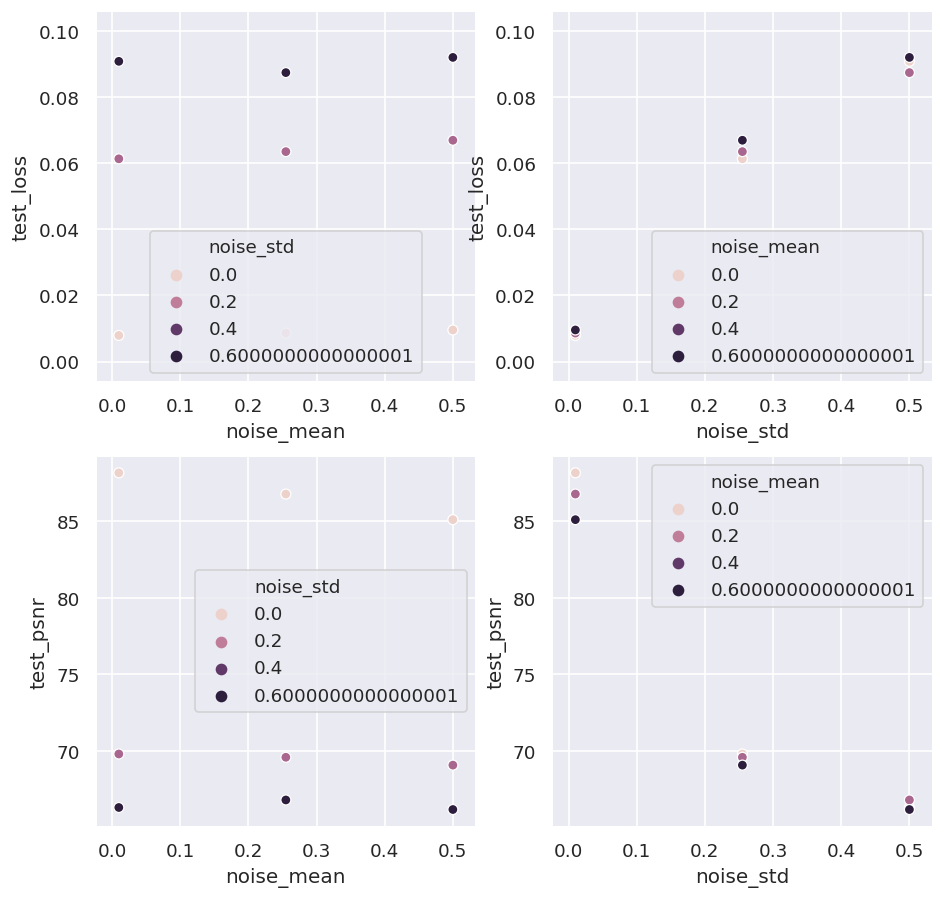

In [10]:
plt.figure(dpi=120, figsize=(9, 9))
plt.subplot(2, 2, 1)
sns.scatterplot(x=results["noise_mean"], hue=results["noise_std"], y=results["test_loss"])
plt.subplot(2, 2, 2)
sns.scatterplot(x=results["noise_std"], hue=results["noise_mean"], y=results["test_loss"])
plt.subplot(2, 2, 3)
sns.scatterplot(x=results["noise_mean"], hue=results["noise_std"], y=results["test_psnr"])
plt.subplot(2, 2, 4)
sns.scatterplot(x=results["noise_std"], hue=results["noise_mean"], y=results["test_psnr"])
plt.show()